In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from statistics import NormalDist

from classiq import *
from classiq.applications.iqae.iqae import IQAE

**Classical Monte Carlo**

Our return distribution is modeled by a normal distribution with mean of 0.15 (15%) and standard deviation of 0.20 (20%). 

In [3]:
def build_normal_return_grid_probs(mu=0.15, sigma=0.20, n_qubits=7, k_sigmas=4.0):
    """
    Build a discretized 1Y return distribution R ~ N(mu, sigma^2) on an N=2^n grid.

    We create N equal-width bins spanning [mu - k_sigmas*sigma, mu + k_sigmas*sigma].
    Probability mass for each bin is computed via Normal CDF differences, then renormalized
    to account for truncation.

    Returns:
      grid_centers: shape (N,) return value representative for each bin (midpoint)
      probs:        shape (N,) probability mass per bin (sums to 1)
      edges:        shape (N+1,) bin edges
      meta:         dict with useful parameters
    """
    N = 2 ** n_qubits
    r_min = mu - k_sigmas * sigma
    r_max = mu + k_sigmas * sigma

    edges = np.linspace(r_min, r_max, N + 1)
    grid_centers = 0.5 * (edges[:-1] + edges[1:])

    # Normal CDF
    nd = NormalDist(mu=mu, sigma=sigma)
    cdf = np.array([nd.cdf(x) for x in edges])

    probs = np.diff(cdf)               # bin masses
    probs = np.maximum(probs, 0.0)     # numerical safety
    probs = probs / probs.sum()        # renormalize after truncation

    meta = {
        "mu": mu,
        "sigma": sigma,
        "n_qubits": n_qubits,
        "N": N,
        "k_sigmas": k_sigmas,
        "r_min": r_min,
        "r_max": r_max,
        "bin_width": (r_max - r_min) / N,
        "trunc_mass": float(cdf[-1] - cdf[0]),  # mass inside [r_min, r_max] before renorm
    }
    return grid_centers, probs, edges, meta


# Example usage
n_qubits = 7
grid, probs, edges, meta = build_normal_return_grid_probs(mu=0.15, sigma=0.20, n_qubits=n_qubits, k_sigmas=4.0)

print("Meta:", meta)
print("Sum probs:", probs.sum())
print("First 5 grid points:", grid[:5])
print("First 5 probs:", probs[:5])


Meta: {'mu': 0.15, 'sigma': 0.2, 'n_qubits': 7, 'N': 128, 'k_sigmas': 4.0, 'r_min': -0.65, 'r_max': 0.9500000000000001, 'bin_width': 0.0125, 'trunc_mass': 0.9999366575163338}
Sum probs: 1.0
First 5 grid points: [-0.64375 -0.63125 -0.61875 -0.60625 -0.59375]
First 5 probs: [9.49682569e-06 1.21456531e-05 1.54727450e-05 1.96344142e-05
 2.48183337e-05]


In [4]:

ALPHA = 0.05          # 5% confidence level for VaR
TOLERANCE = 0.05     # Convergence tolerance
grid_points = grid    # Rename to match function expectations
# Calculate the true VaR for comparison (5th percentile of normal distribution)
from scipy.stats import norm
mu, sigma = 0.15, 0.20
VAR = norm.ppf(ALPHA, loc=mu, scale=sigma)  # Should be around -0.179
# Make qubit counts consistent
num_qubits = 7  # Match the distribution grid size
n_qubits = num_qubits

In [5]:
def calc_alpha(index: int, probs: list[float]):
    sum_probs = sum([probs[i] for i in range(index)])
    return sum_probs

def update_index(index: int, required_alpha: float, alpha_v: float, search_size: int):
    if alpha_v < required_alpha:
        return index + search_size
    return index - search_size

def print_status(v, alpha_v, search_size, index):
    print(f"v: {v}, alpha_v: {alpha_v}")
    print(f"{search_size=}")
    print(f"{index=}")
    print("------------------------")

def print_results(grid_points, index, probs):
    print(f"Value at risk at {ALPHA*100}%: {grid_points[index]})")
    global VAR
    print(f"Real VaR", VAR)
    return index

def value_at_risk(required_alpha, index, calc_alpha_func=calc_alpha):
    v = probs[index]
    alpha_v = calc_alpha_func(index, probs)
    search_size = index // 2
    print_status(v, alpha_v, search_size, index)

    # Tolerance represents the accuracy of the alpha we aim to get
    while (not np.isclose(alpha_v, required_alpha, atol=TOLERANCE)) and search_size > 0:
        index = update_index(index, required_alpha, alpha_v, search_size)
        # Binary search, divided by 2 - as we know the function is always growing in that part of the graph.
        search_size = search_size // 2
        v = grid_points[index]
        alpha_v = calc_alpha_func(index, probs)
        print_status(v, alpha_v, search_size, index)

    print_results(grid_points, index, probs)
    print_results(grid_points, index, probs)

Over a time horizon of a year and a confidence interval of (0.95) 95%, we use a Monte Carlo simulation to estimate the value at risk (VaR) of our return distribution.

**Iterative Quantum Amplitude Estimation (QAE)**

The goal of QAE is to estimate the probability (or amplitude) of a certain outcome from a quantum circuit. In our case, we will use this to estimate our value at risk.

In [6]:
@qfunc(synthesize_separately=True)
def state_preparation(asset: QArray[QBit], ind: QBit):
    load_distribution(asset=asset)
    payoff(asset=asset, ind=ind)

@qfunc
def load_distribution(asset: QNum):
    inplace_prepare_state(probs, bound=0, target=asset)

@qperm
def payoff(asset: Const[QNum], ind: QBit):
    ind ^= asset < GLOBAL_INDEX

In [7]:
written_qmod = False

def calc_alpha_quantum_ci(index: int, probs: list[float], epsilon: float = 0.05, alpha: float = 0.01, show_once: bool = False):
    """
    Estimate CDF(index) = P(asset < index) using IQAE, and return:
      - measured_payoff (float)
      - confidence_interval (tuple: (low, high))
    """
    global GLOBAL_INDEX, written_qmod
    GLOBAL_INDEX = int(index)

    iqae = IQAE(
        state_prep_op=state_preparation,
        problem_vars_size=num_qubits,
        constraints=Constraints(max_width=28),
        preferences=Preferences(machine_precision=num_qubits),
    )

    qprog = iqae.get_qprog()

    if show_once and (not written_qmod):
        written_qmod = True
        show(qprog)

    iqae_res = iqae.run(epsilon=float(epsilon), alpha=float(alpha))

    measured_payoff = float(iqae_res.estimation)
    ci_low, ci_high = map(float, iqae_res.confidence_interval)

    # Optional prints (keep your existing behavior if you want)
    print("Measured Payoff:", measured_payoff)
    print("Confidence Interval:", np.array([ci_low, ci_high]))

    return measured_payoff, (ci_low, ci_high)


In [8]:
def adaptive_var_bisection_quantum(
    required_alpha: float,
    probs: list[float],
    n_bins: int,
    index_to_value,  # function: index -> v (return threshold), e.g. lambda j: edges[j] or grid_points[j]
    eps_start: float = 0.05,
    eps_min: float = 0.002,
    eps_shrink: float = 0.5,
    alpha_iqae: float = 0.01,
    prob_tol: float = 1e-3,
    index_tol: int = 1,
    max_bisect_iters: int = 40,
    max_refine_iters: int = 10,
    show_once: bool = False,
    verbose: bool = True,
):
    """
    Returns:
      j_hat (int): smallest index s.t. CDF(j_hat) >= required_alpha
      v_hat (float): corresponding threshold value
      history (list): per-step diagnostics
    """
    lo, hi = 0, n_bins  # CDF(lo)=0, CDF(hi)=1 in principle for full support

    history = []

    for it in range(max_bisect_iters):
        if hi - lo <= index_tol:
            break

        mid = (lo + hi) // 2

        # adaptive refinement at this mid
        eps = eps_start
        for ref in range(max_refine_iters):
            a_hat, (ci_l, ci_u) = calc_alpha_quantum_ci(
                mid, probs, epsilon=eps, alpha=alpha_iqae, show_once=(show_once and it == 0 and ref == 0)
            )

            v_mid = float(index_to_value(mid))
            history.append({
                "iter": it,
                "ref": ref,
                "lo": lo, "hi": hi, "mid": mid,
                "v_mid": v_mid,
                "a_hat": a_hat,
                "ci": (ci_l, ci_u),
                "epsilon": eps,
            })

            if verbose:
                print(
                    f"[it={it:02d} ref={ref:02d}] lo={lo:4d} hi={hi:4d} mid={mid:4d} "
                    f"v={v_mid:+.6f} a={a_hat:.6f} CI=[{ci_l:.6f},{ci_u:.6f}] eps={eps:.4g}"
                )

            # CI-based decisive direction
            if ci_u < required_alpha - prob_tol:
                # Definitely below target -> need larger index
                lo = mid
                break
            elif ci_l >= required_alpha + prob_tol:
                # Definitely above target -> need smaller index
                hi = mid
                break
            else:
                # CI overlaps target -> tighten precision and retry
                if eps <= eps_min:
                    # fallback to point estimate if we hit min epsilon
                    if a_hat < required_alpha:
                        lo = mid
                    else:
                        hi = mid
                    break
                eps *= eps_shrink

    j_hat = hi
    v_hat = float(index_to_value(j_hat))
    return j_hat, v_hat, history


In [9]:
num_qubits = 7
GLOBAL_INDEX = 0

n_bins = len(probs)

required_alpha = 0.05  # 5% left-tail of returns

# Map an index to a threshold value:
# - If your oracle marks (asset < index), the natural threshold is edges[index]
index_to_value = lambda j: edges[j]

var_index, var_value, history = adaptive_var_bisection_quantum(
    required_alpha=required_alpha,
    probs=probs,
    n_bins=n_bins,
    index_to_value=index_to_value,
    eps_start=0.05,
    eps_min=0.002,
    eps_shrink=0.5,
    alpha_iqae=0.01,
    prob_tol=1e-3,
    index_tol=1,
    verbose=True,
)

print("VaR index:", var_index)
print("VaR return threshold:", var_value)
print("VaR (loss = -return):", -var_value)


Measured Payoff: 0.49560546875
Confidence Interval: [0.45608648 0.53512446]
[it=00 ref=00] lo=   0 hi= 128 mid=  64 v=+0.150000 a=0.495605 CI=[0.456086,0.535124] eps=0.05
Measured Payoff: 0.022543154025406055
Confidence Interval: [0.02019227 0.02489403]
[it=01 ref=00] lo=   0 hi=  64 mid=  32 v=-0.250000 a=0.022543 CI=[0.020192,0.024894] eps=0.05
Measured Payoff: 0.1616420033913768
Confidence Interval: [0.15469585 0.16858816]
[it=02 ref=00] lo=  32 hi=  64 mid=  48 v=-0.050000 a=0.161642 CI=[0.154696,0.168588] eps=0.05
Measured Payoff: 0.0671401497549643
Confidence Interval: [0.06494029 0.06934001]
[it=03 ref=00] lo=  32 hi=  48 mid=  40 v=-0.150000 a=0.067140 CI=[0.064940,0.069340] eps=0.05
Measured Payoff: 0.04011083156002647
Confidence Interval: [0.03667504 0.04354663]
[it=04 ref=00] lo=  32 hi=  40 mid=  36 v=-0.200000 a=0.040111 CI=[0.036675,0.043547] eps=0.05
Measured Payoff: 0.05313307834738911
Confidence Interval: [0.04826981 0.05799635]
[it=05 ref=00] lo=  36 hi=  40 mid=  38 

Measured Payoff: 0.49707031249999994
Confidence Interval: [0.45882427 0.53531636]
Measured Payoff: 0.022656236879644614
Confidence Interval: [0.02037603 0.02493645]
Measured Payoff: 0.15869140625
Confidence Interval: [0.12044536 0.19693745]
Measured Payoff: 0.06054687500000001
Confidence Interval: [0.02230083 0.09879292]
Measured Payoff: 0.03950858153503151
Confidence Interval: [0.03623104 0.04278612]
Measured Payoff: 0.05347917661672209
Confidence Interval: [0.04872328 0.05823507]
Measured Payoff: 0.046834994974789435
Confidence Interval: [0.04289259 0.0507774 ]
Measured Payoff: 0.48779296874999994
Confidence Interval: [0.44954692 0.52603901]
Measured Payoff: 0.022860766350906156
Confidence Interval: [0.02057142 0.02515011]
Measured Payoff: 0.16357421875
Confidence Interval: [0.12532817 0.20182026]
Measured Payoff: 0.06054687500000001
Confidence Interval: [0.02230083 0.09879292]
Measured Payoff: 0.04092088289188549
Confidence Interval: [0.03752976 0.044312  ]
Measured Payoff: 0.054040

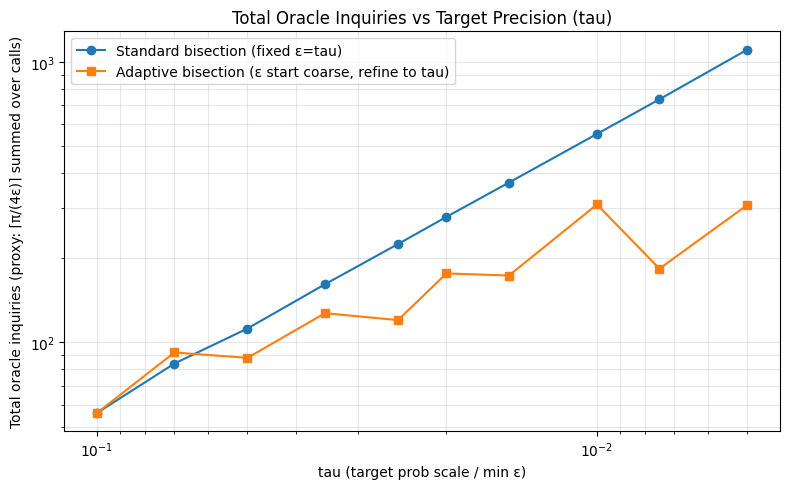

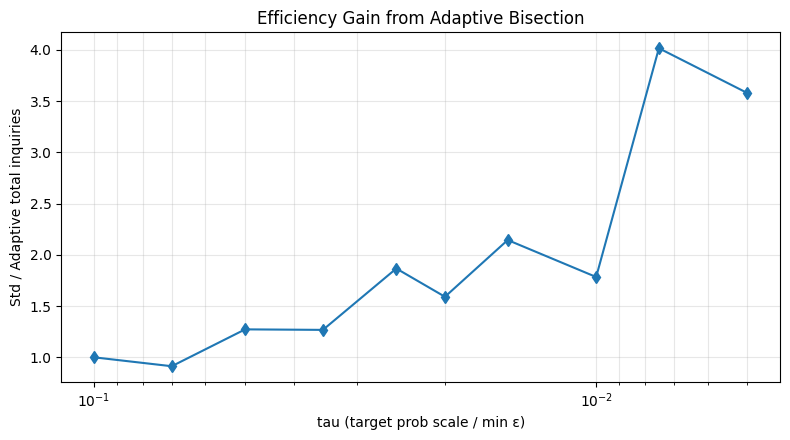

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Goal:
# Compare TOTAL oracle inquiries (Grover/Q applications) needed
# to compute VaR using:
#   (1) Standard bisection: fixed precision (same epsilon each CDF query)
#   (2) Adaptive bisection: start coarse; refine epsilon only when needed
#
# We plot total oracle inquiries vs a control parameter: tau,
# where tau is the target probability tolerance / minimum epsilon.
# ============================================================

# ---------- Helper: convert epsilon <-> "oracle inquiries" ----------
# For QAE/IQAE, a common proxy is: error ~ O(1/M), M ~ O(1/epsilon).
# Your earlier mapping was epsilon ~ pi / (4 * n_queries).
def queries_from_epsilon(epsilon: float) -> int:
    epsilon = float(np.clip(epsilon, 1e-8, 0.5))
    return int(np.ceil(np.pi / (4.0 * epsilon)))

# ---------- MUST EXIST from your notebook ----------
# calc_alpha_quantum_ci(index, probs, epsilon=..., alpha=...) -> (a_hat, (ci_low, ci_high))
# probs, edges (or grid_points), num_qubits, GLOBAL_INDEX, state_preparation, etc.

# ---------- Index-to-threshold conversion (pick one consistently) ----------
# If your oracle marks: (asset < index), the natural threshold is edges[index].
index_to_value = lambda j: edges[int(j)]  # requires 'edges' defined

# ============================================================
# Instrumented CDF query wrapper
# Counts "oracle inquiries" via the epsilon used in each IQAE call.
# ============================================================
class OracleCounter:
    def __init__(self):
        self.total_queries = 0
        self.calls = 0
        self.log = []  # (index, epsilon, queries_used, est, ci)

    def query_cdf(self, index: int, epsilon: float, alpha_iqae: float = 0.01):
        est, ci = calc_alpha_quantum_ci(index, probs, epsilon=epsilon, alpha=alpha_iqae, show_once=False)
        q = queries_from_epsilon(epsilon)
        self.total_queries += q
        self.calls += 1
        self.log.append((int(index), float(epsilon), int(q), float(est), (float(ci[0]), float(ci[1]))))
        return float(est), (float(ci[0]), float(ci[1]))

# ============================================================
# Standard bisection (fixed epsilon at every midpoint)
# Uses point estimate only (like typical "non-adaptive" baseline).
# Stops when hi - lo <= index_tol.
# ============================================================
def var_standard_bisection(
    target_prob: float,
    n_bins: int,
    fixed_epsilon: float,
    alpha_iqae: float = 0.01,
    index_tol: int = 1,
    max_iters: int = 50,
):
    counter = OracleCounter()
    lo, hi = 0, n_bins

    for _ in range(max_iters):
        if hi - lo <= index_tol:
            break

        mid = (lo + hi) // 2
        est, _ci = counter.query_cdf(mid, epsilon=fixed_epsilon, alpha_iqae=alpha_iqae)

        # Standard decision (no CI use)
        if est < target_prob:
            lo = mid
        else:
            hi = mid

    var_index = hi
    var_value = index_to_value(var_index)
    return var_index, float(var_value), counter

# ============================================================
# Adaptive bisection
# - Start with eps_start (coarse)
# - If CI overlaps target, tighten epsilon by shrink factor
# - Stop tightening at eps_min (= tau) or max_refine
# - Use CI-based direction decisions for robustness
# ============================================================
def var_adaptive_bisection(
    target_prob: float,
    n_bins: int,
    eps_start: float,
    eps_min: float,
    eps_shrink: float = 0.5,
    alpha_iqae: float = 0.01,
    prob_guard: float = 0.0,     # optional margin: require CI separation by this amount
    index_tol: int = 1,
    max_bisect_iters: int = 50,
    max_refine_iters: int = 12,
):
    counter = OracleCounter()
    lo, hi = 0, n_bins

    for _ in range(max_bisect_iters):
        if hi - lo <= index_tol:
            break

        mid = (lo + hi) // 2

        # refine at fixed mid only if needed
        eps = float(eps_start)
        for _r in range(max_refine_iters):
            est, (ci_l, ci_u) = counter.query_cdf(mid, epsilon=eps, alpha_iqae=alpha_iqae)

            # CI-based decision
            if ci_u < target_prob - prob_guard:
                lo = mid
                break
            elif ci_l >= target_prob + prob_guard:
                hi = mid
                break
            else:
                # not decisive: tighten epsilon
                if eps <= eps_min:
                    # fallback to point estimate if we hit min epsilon
                    if est < target_prob:
                        lo = mid
                    else:
                        hi = mid
                    break
                eps = max(eps_min, eps * eps_shrink)

    var_index = hi
    var_value = index_to_value(var_index)
    return var_index, float(var_value), counter

# ============================================================
# Sweep an "appropriate parameter": tau = eps_min = target probability accuracy scale
#
# For fairness:
# - Standard bisection uses fixed_epsilon = tau at every step
# - Adaptive bisection starts coarse (eps_start) but can refine down to eps_min=tau
#
# We then compare total oracle inquiries vs tau.
# ============================================================
def compare_oracle_inquiries_vs_tau(
    confidence_level: float = 0.95,
    tail: str = "lower",
    taus = None,
    eps_start: float = 0.10,
    alpha_iqae: float = 0.01,
):
    n_bins = len(probs)

    # VaR target probability (left-tail for returns):
    if tail == "lower":
        target_prob = 1.0 - confidence_level  # e.g. 0.05 for 95% VaR
    elif tail == "upper":
        target_prob = confidence_level
    else:
        raise ValueError("tail must be 'lower' or 'upper'")

    if taus is None:
        taus = [0.10, 0.07, 0.05, 0.035, 0.025, 0.02, 0.015, 0.01, 0.0075, 0.005]

    out = {
        "tau": [],
        "standard_total_queries": [],
        "adaptive_total_queries": [],
        "standard_var_value": [],
        "adaptive_var_value": [],
        "standard_calls": [],
        "adaptive_calls": [],
        "ratio_standard_over_adaptive": [],
    }

    for tau in taus:
        tau = float(tau)

        # --- Standard ---
        j_std, v_std, c_std = var_standard_bisection(
            target_prob=target_prob,
            n_bins=n_bins,
            fixed_epsilon=tau,
            alpha_iqae=alpha_iqae
        )

        # --- Adaptive ---
        j_adp, v_adp, c_adp = var_adaptive_bisection(
            target_prob=target_prob,
            n_bins=n_bins,
            eps_start=eps_start,
            eps_min=tau,
            eps_shrink=0.5,
            alpha_iqae=alpha_iqae
        )

        out["tau"].append(tau)
        out["standard_total_queries"].append(c_std.total_queries)
        out["adaptive_total_queries"].append(c_adp.total_queries)
        out["standard_var_value"].append(v_std)
        out["adaptive_var_value"].append(v_adp)
        out["standard_calls"].append(c_std.calls)
        out["adaptive_calls"].append(c_adp.calls)
        out["ratio_standard_over_adaptive"].append(c_std.total_queries / max(1, c_adp.total_queries))

        print(
            f"tau={tau:.4g} | "
            f"Std queries={c_std.total_queries:6d} (calls={c_std.calls:3d}) | "
            f"Adp queries={c_adp.total_queries:6d} (calls={c_adp.calls:3d}) | "
            f"ratio={out['ratio_standard_over_adaptive'][-1]:.2f} | "
            f"VaR std={v_std:+.6f}, VaR adp={v_adp:+.6f}"
        )

    return out

# ============================================================
# Run the comparison + plot
# ============================================================
results = compare_oracle_inquiries_vs_tau(
    confidence_level=0.95,
    tail="lower",
    taus=[0.10, 0.07, 0.05, 0.035, 0.025, 0.02, 0.015, 0.01, 0.0075, 0.005],
    eps_start=0.10,
    alpha_iqae=0.01,
)

tau = np.array(results["tau"])
q_std = np.array(results["standard_total_queries"])
q_adp = np.array(results["adaptive_total_queries"])
ratio = np.array(results["ratio_standard_over_adaptive"])

plt.figure(figsize=(8, 5))
plt.loglog(tau, q_std, marker='o', label="Standard bisection (fixed ε=tau)")
plt.loglog(tau, q_adp, marker='s', label="Adaptive bisection (ε start coarse, refine to tau)")
plt.gca().invert_xaxis()
plt.xlabel("tau (target prob scale / min ε)")
plt.ylabel("Total oracle inquiries (proxy: ⌈π/(4ε)⌉ summed over calls)")
plt.title("Total Oracle Inquiries vs Target Precision (tau)")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4.5))
plt.semilogx(tau, ratio, marker='d')
plt.gca().invert_xaxis()
plt.xlabel("tau (target prob scale / min ε)")
plt.ylabel("Std / Adaptive total inquiries")
plt.title("Efficiency Gain from Adaptive Bisection")
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()


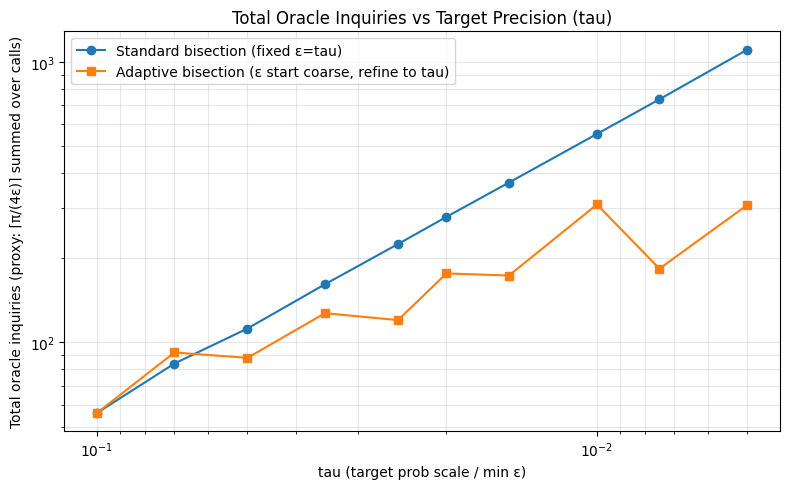

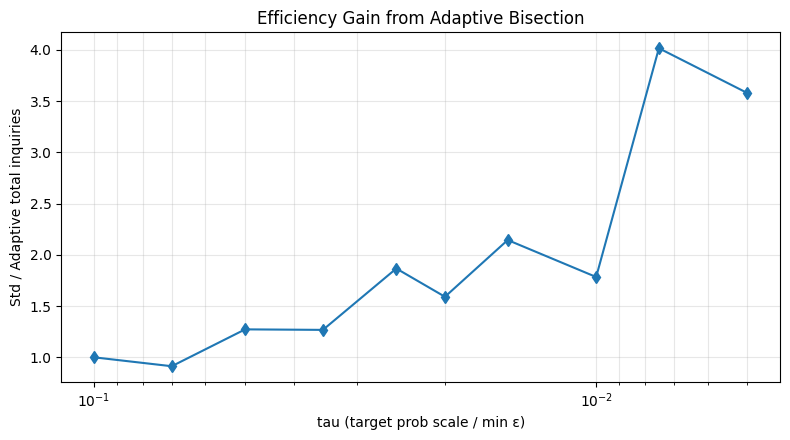

In [12]:
tau = np.array(results["tau"])
q_std = np.array(results["standard_total_queries"])
q_adp = np.array(results["adaptive_total_queries"])
ratio = np.array(results["ratio_standard_over_adaptive"])

plt.figure(figsize=(8, 5))
plt.loglog(tau, q_std, marker='o', label="Standard bisection (fixed ε=tau)")
plt.loglog(tau, q_adp, marker='s', label="Adaptive bisection (ε start coarse, refine to tau)")
plt.gca().invert_xaxis()
plt.xlabel("tau (target prob scale / min ε)")
plt.ylabel("Total oracle inquiries (proxy: ⌈π/(4ε)⌉ summed over calls)")
plt.title("Total Oracle Inquiries vs Target Precision (tau)")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4.5))
plt.semilogx(tau, ratio, marker='d')
plt.gca().invert_xaxis()
plt.xlabel("tau (target prob scale / min ε)")
plt.ylabel("Std / Adaptive total inquiries")
plt.title("Efficiency Gain from Adaptive Bisection")
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
tau = np.array(results["tau"])

In [18]:
ratio 

array([1.        , 0.91304348, 1.27272727, 1.26771654, 1.86666667,
       1.59090909, 2.14450867, 1.78387097, 4.01639344, 3.57928803])